In [1]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

# Assuming MODEL is already set to the path of your model
MODEL = "./results/checkpoint-500"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Load the comments and stock prices data
tweets_df = pd.read_csv('./stock_tweets.csv')
stock_prices_df = pd.read_csv('./stock_yfinance_data.csv')

def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)


# Preprocess and predict sentiment for each comment
def get_sentiment(text):
    processed_text = preprocess(text)
    encoded_input = tokenizer(processed_text, return_tensors='pt')
    with torch.no_grad():  # This line ensures gradients are not computed
        output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return scores


In [35]:
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader, SequentialSampler, TensorDataset
# Check if CUDA is available and set the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Move the model to the device
model.to(device)
batch_size = 128
# Tokenize all comments
encoded_comments = tokenizer(list(tweets_df['Tweet']), padding=True, truncation=True, return_tensors='pt')

# Create a TensorDataset and DataLoader
dataset = TensorDataset(encoded_comments['input_ids'], encoded_comments['attention_mask'])
dataloader = DataLoader(dataset, sampler=SequentialSampler(dataset), batch_size=batch_size)

# Now, iterate over batches and make predictions using the GPU
model.eval()  # Set the model to evaluation mode
negative_scores = []
neutral_scores = []
positive_scores = []

with torch.no_grad():
    for batch in tqdm(dataloader, desc="Evaluating", unit="batch"):
        input_ids, attention_mask = batch

        # Move the batch to the device (e.g., GPU or CPU)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        # Compute the logits
        outputs = model(input_ids, attention_mask=attention_mask)
        scores = outputs.logits.detach().cpu().numpy()  # Move the logits back to CPU
        scores = softmax(scores, axis=1)

        # Extend the lists with the individual scores
        negative_scores.extend(scores[:, 0])
        neutral_scores.extend(scores[:, 1])
        positive_scores.extend(scores[:, 2])

# Add the individual sentiment scores to the DataFrame
tweets_df['negative_sentiment'] = negative_scores
tweets_df['neutral_sentiment'] = neutral_scores
tweets_df['positive_sentiment'] = positive_scores



Using device: cuda:0


Evaluating: 100%|██████████| 632/632 [13:57<00:00,  1.32s/batch]


In [42]:
tweets_df = tweets_df.drop('sentiment_scores',axis=1)

In [43]:
tweets_df

Date                                              Tweet  \
0      2022-09-29  Mainstream media has done an amazing job at br...   
1      2022-09-29  Tesla delivery estimates are at around 364k fr...   
2      2022-09-29  3/ Even if I include 63.0M unvested RSUs as of...   
3      2022-09-29  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...   
4      2022-09-29  @RealDanODowd @Tesla Stop trying to kill kids,...   
...           ...                                                ...   
80788  2021-10-07  Some of the fastest growing tech stocks on the...   
80789  2021-10-04  With earnings on the horizon, here is a quick ...   
80790  2021-10-01  Our record delivery results are a testimony of...   
80791  2021-10-01  We delivered 10,412 Smart EVs in Sep 2021, rea...   
80792  2021-09-30  Why can XPeng P5 deliver outstanding performan...   

      Stock Name Company Name  positive_sentiment  negative_sentiment  \
0           TSLA  Tesla, Inc.            0.364114            0.635286   
1           TSLA  Tesla, Inc.            0.818096            0.181013   
2           TSLA  Tesla, Inc.            0.750097            0.248165   
3           TSLA  Tesla, Inc.            0.387695            0.611649   
4           TSLA  Tesla, Inc.            0.043993            0.955467   
...          ...          ...                 ...                 ...   
80788       XPEV   XPeng Inc.            0.972556            0.027041   
80789       XPEV   XPeng Inc.            0.956286            0.043358   
80790       XPEV   XPeng Inc.            0.955711            0.043792   
80791       XPEV   XPeng Inc.            0.968686            0.030910   
80792       XPEV   XPeng Inc.            0.956787            0.042812   

       neutral_sentiment  
0               0.000600  
1               0.000890  
2               0.001738  
3               0.000656  
4               0.000540  
...                  ...  
80788           0.000403  
80789           0.000356  
80790           0.000497  
80791           0.000404  
80792           0.000402  

[80793 rows x 7 columns]

In [44]:
# Saving the tweets dataframe with sentiment scores to a CSV file
tweets_df.to_csv('./sentiment_scores.csv', index=False)



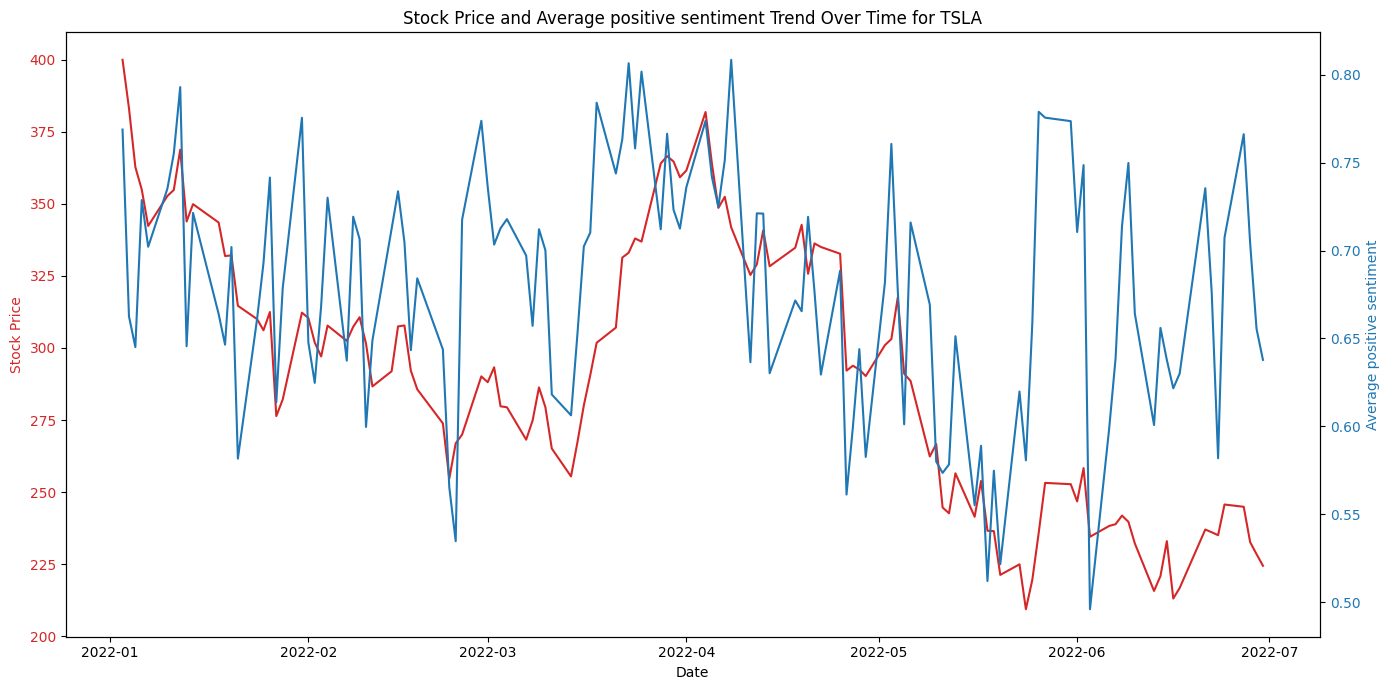

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

sentiment_type = 'positive_sentiment'


# Assuming sentiment_scores is already a list of floats and split into three columns
tweets_df = pd.read_csv('./sentiment_scores.csv')
stock_prices_df = pd.read_csv('./stock_yfinance_data.csv')

# Convert the 'Date' columns to datetime and normalize to just the date
tweets_df['Date'] = pd.to_datetime(tweets_df['Date']).dt.date
stock_prices_df['Date'] = pd.to_datetime(stock_prices_df['Date']).dt.date

# Merge the sentiment data with the stock prices data on the date and stock name
merged_df = pd.merge(stock_prices_df, tweets_df, left_on=['Date', 'Stock Name'], right_on=['Date', 'Stock Name'])

# Group by Date and Stock Name, and then calculate the mean sentiment
average_sentiment_per_day = merged_df.groupby(['Date', 'Stock Name'])[sentiment_type].mean().reset_index()

# Merge the average sentiment back with the stock prices
merged_with_average_sentiment = pd.merge(stock_prices_df, average_sentiment_per_day, on=['Date', 'Stock Name'])

# Filter for a specific stock
specific_stock_df = merged_with_average_sentiment[merged_with_average_sentiment['Stock Name'] == 'TSLA']

# Set the date as the index for the specific stock
specific_stock_df.set_index('Date', inplace=True)

start_date = '2022-01-01'
end_date = '2022-06-30'

# Convert strings to datetime
start_date = pd.to_datetime(start_date).date()
end_date = pd.to_datetime(end_date).date()

# Filter the DataFrame for the date range
specific_stock_df = specific_stock_df[(specific_stock_df.index >= start_date) & (specific_stock_df.index <= end_date)]


# Plotting
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot the stock prices
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Price', color=color)
ax1.plot(specific_stock_df.index, specific_stock_df['Close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the average positive sentiment score
color = 'tab:blue'
ax2.set_ylabel(f'Average {sentiment_type.replace("_"," ")}', color=color)
ax2.plot(specific_stock_df.index, specific_stock_df[sentiment_type], color=color, marker=' ')
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout
plt.title(f'Stock Price and Average {sentiment_type.replace("_"," ")} Trend Over Time for TSLA')
fig.tight_layout()

# Show the plot
plt.show()


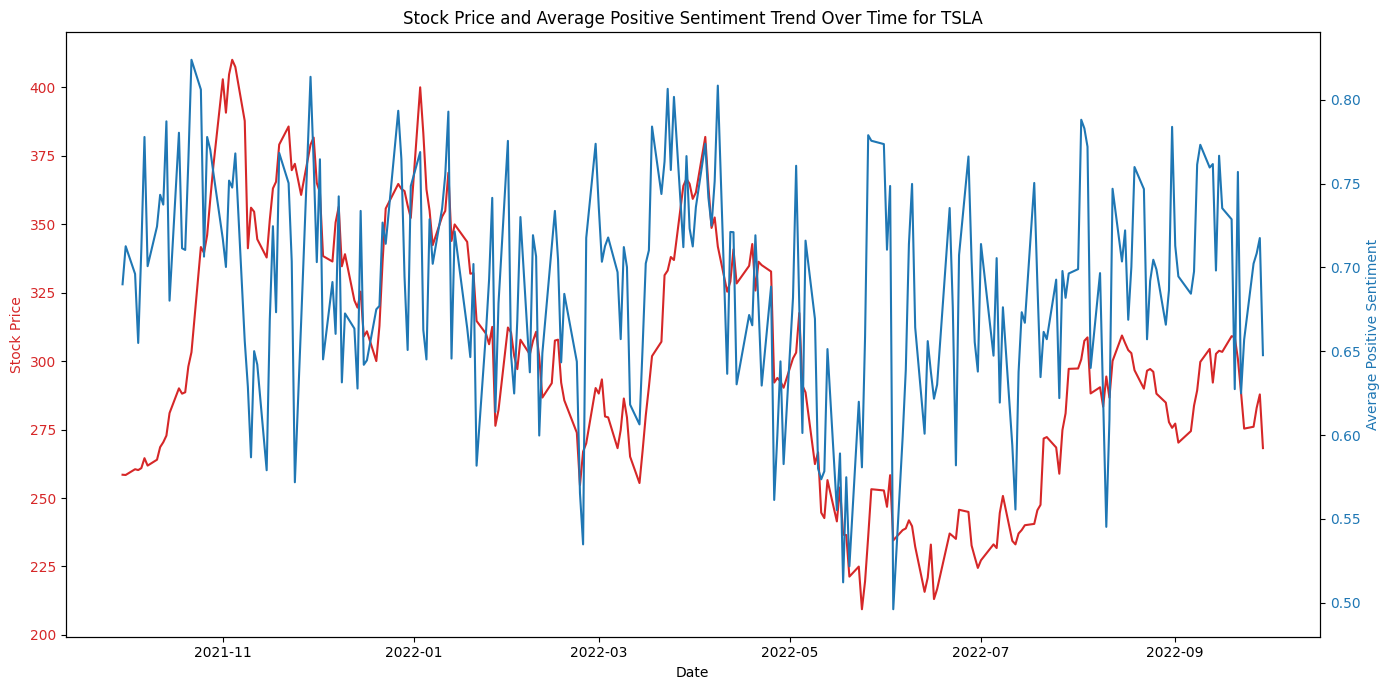

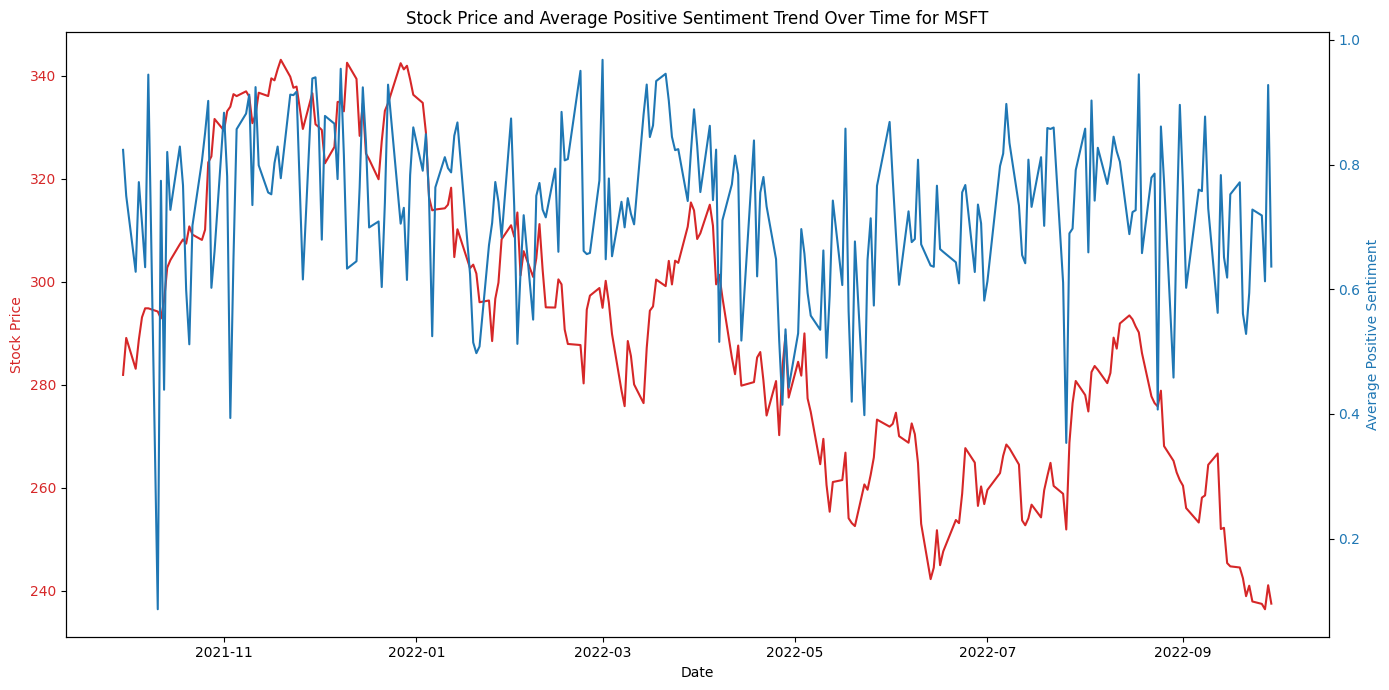

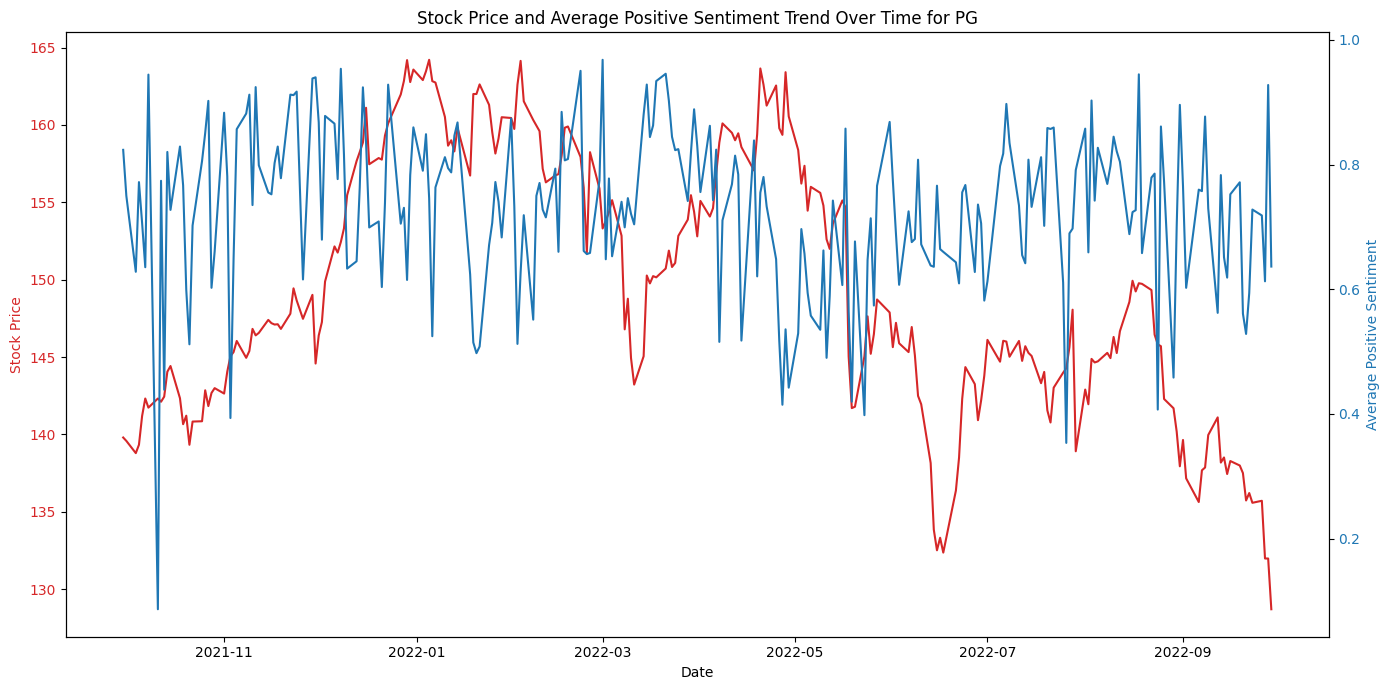

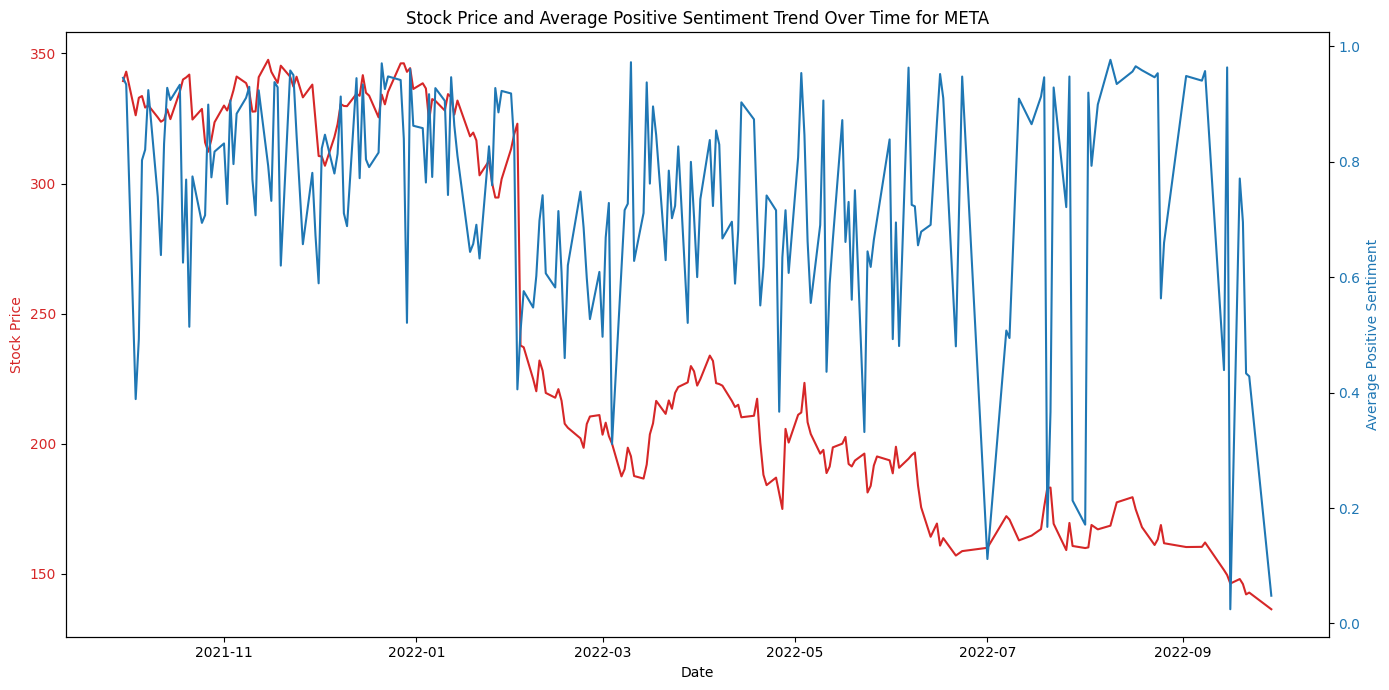

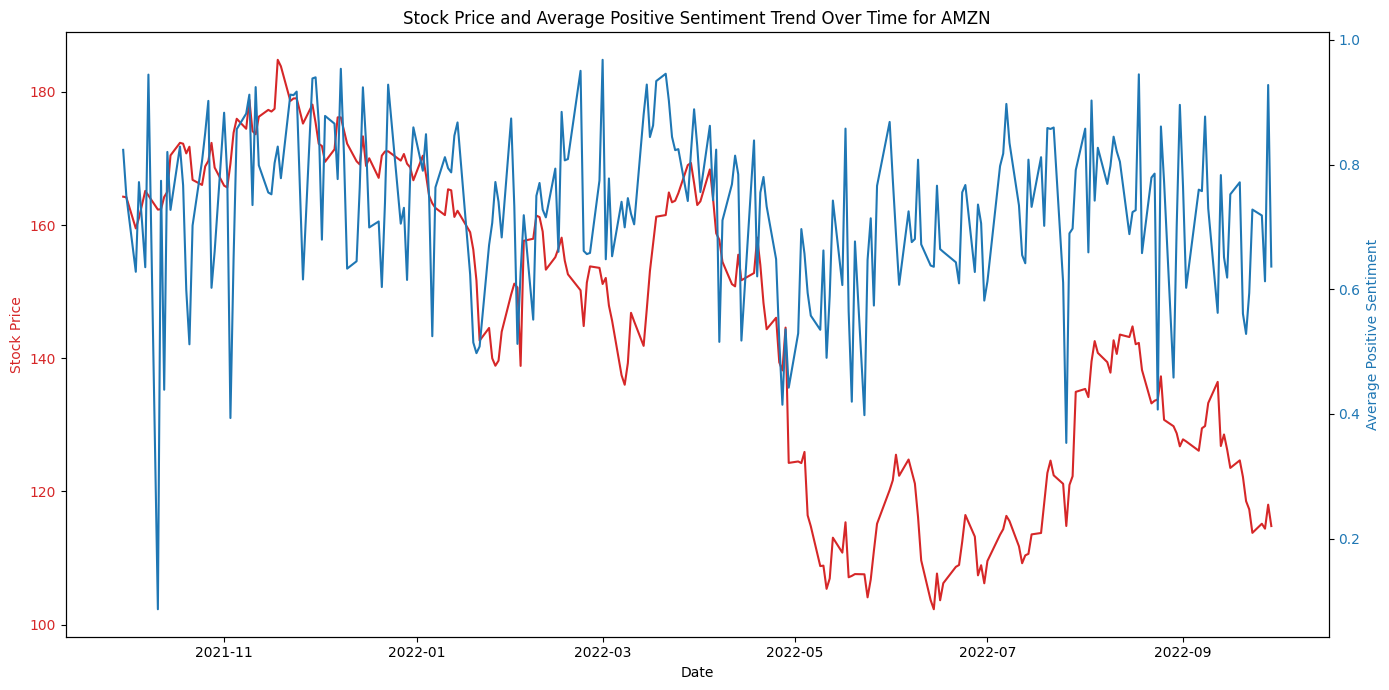

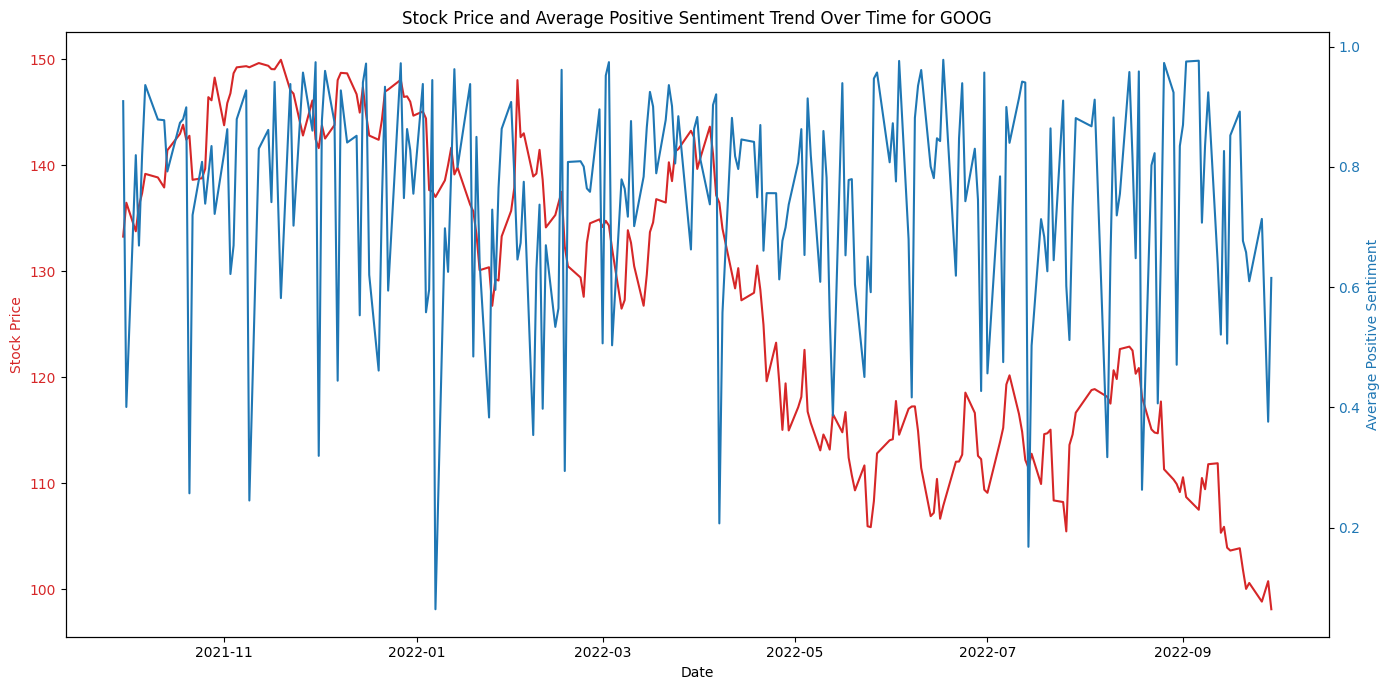

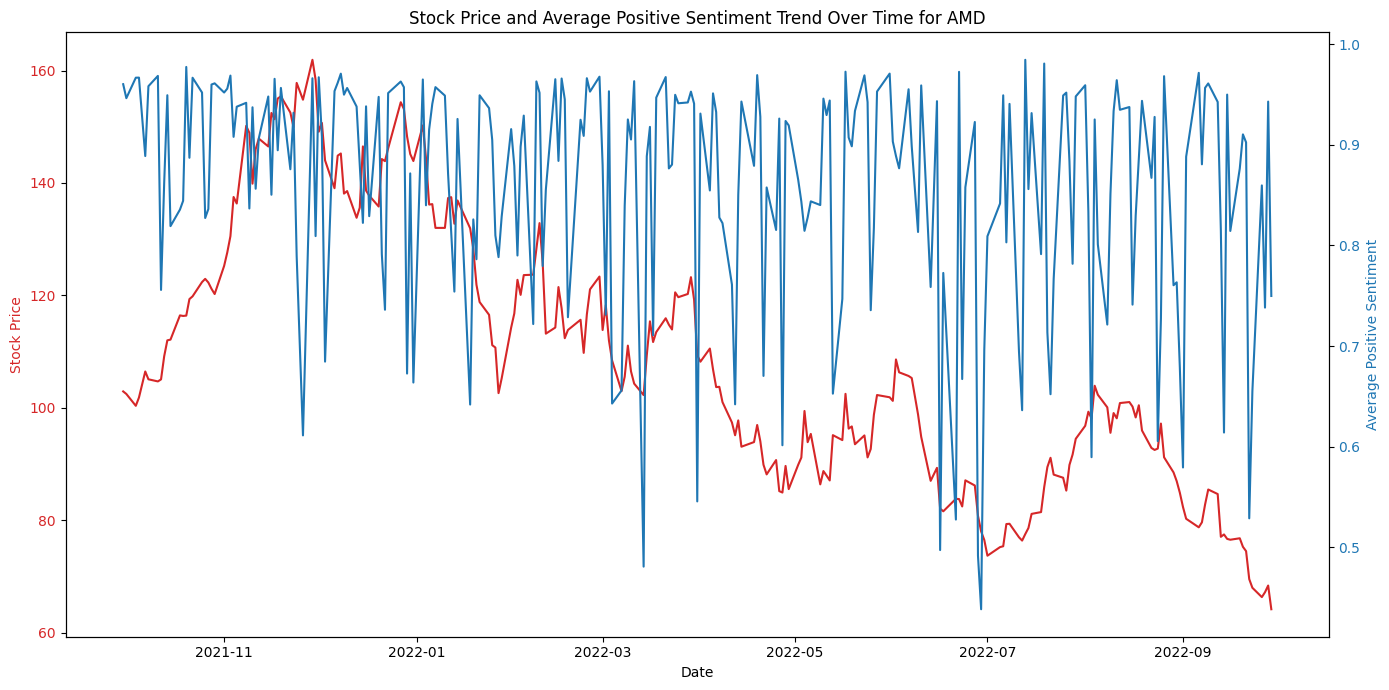

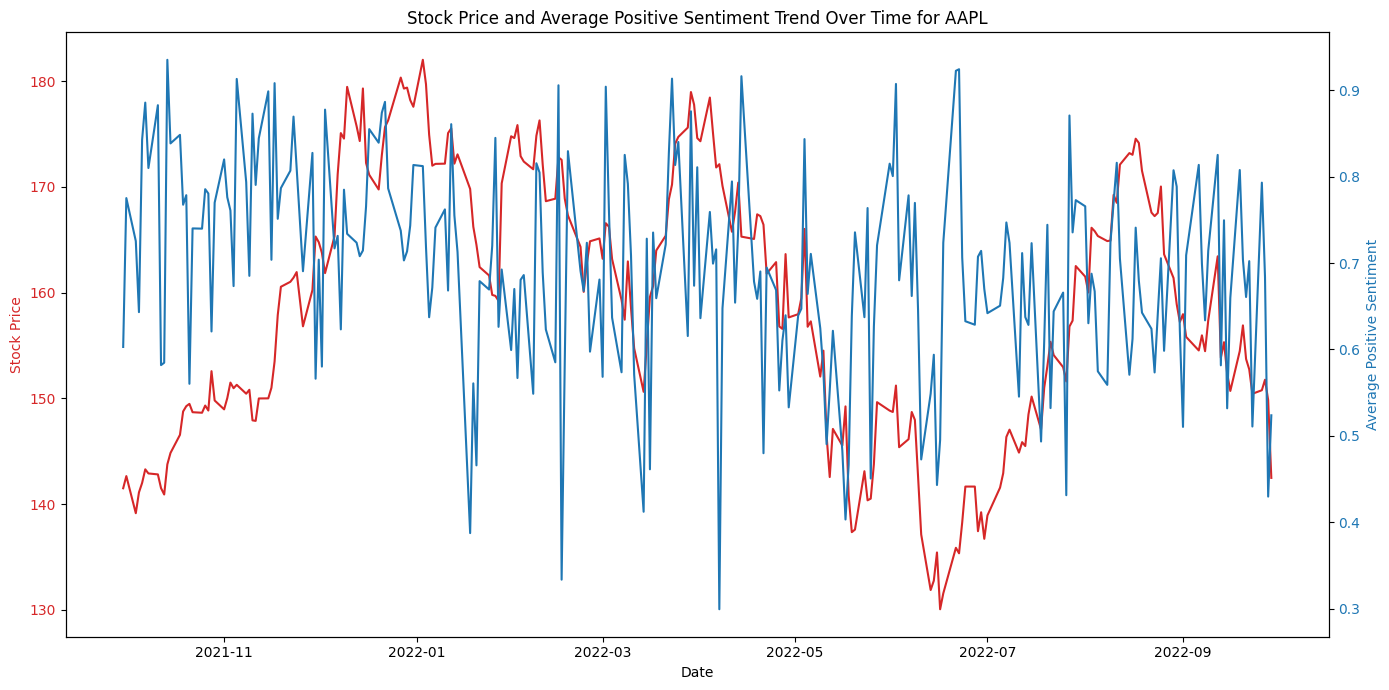

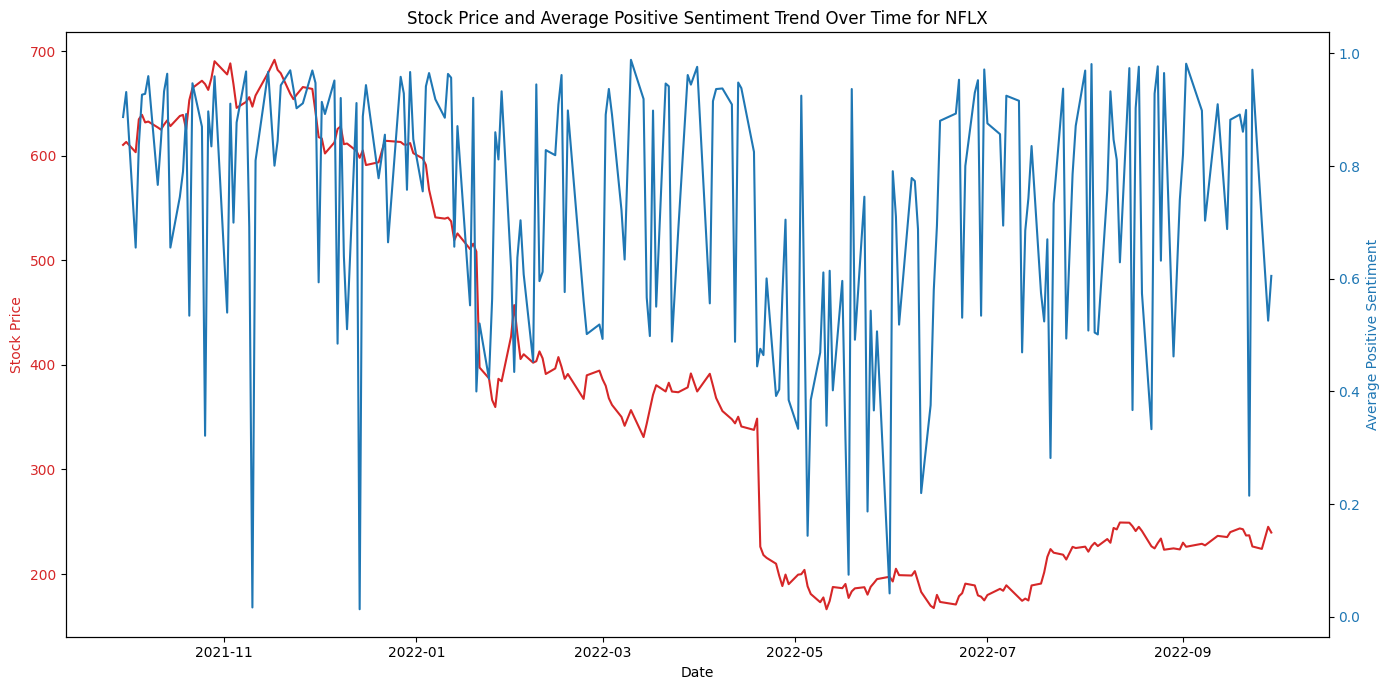

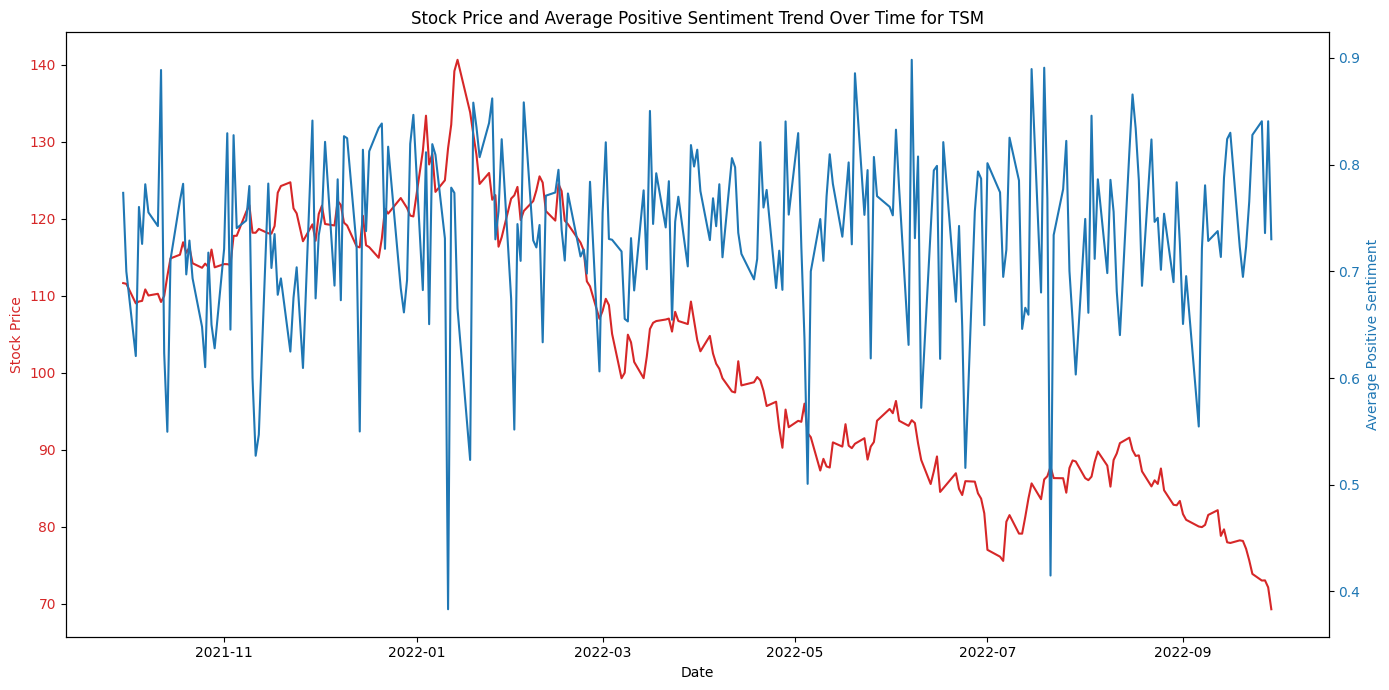

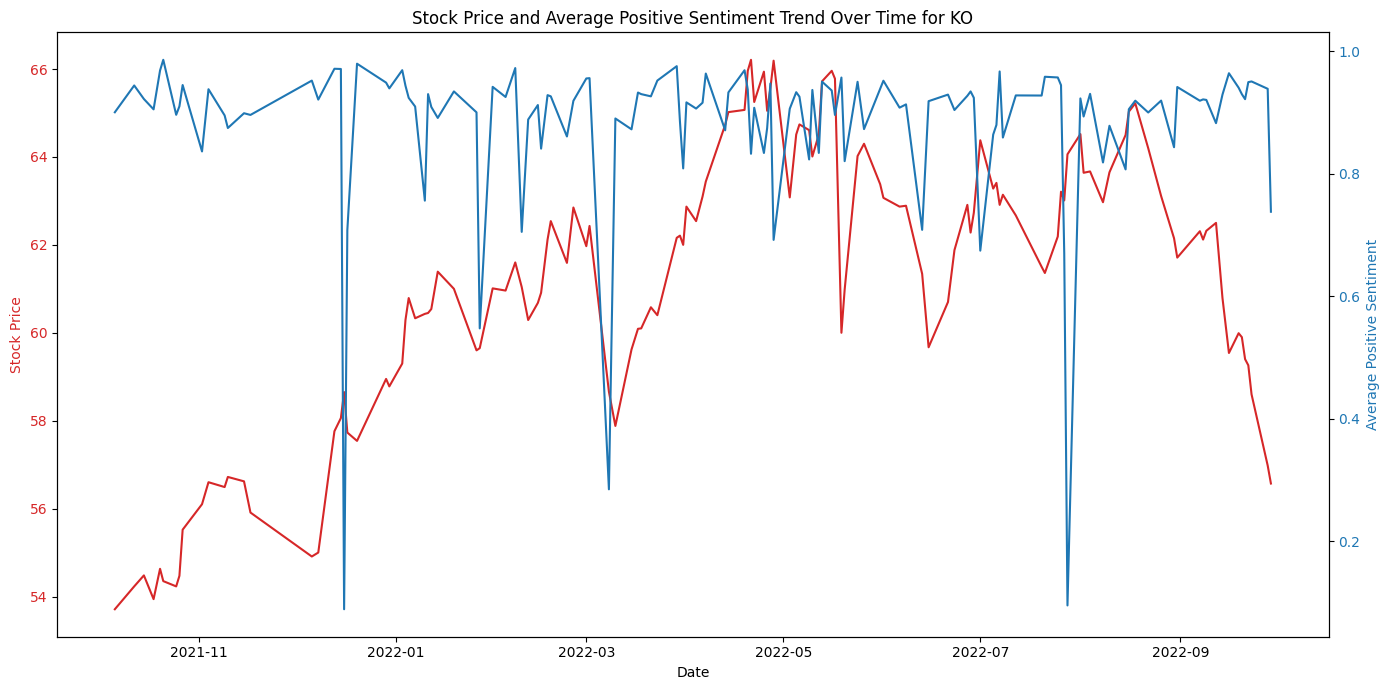

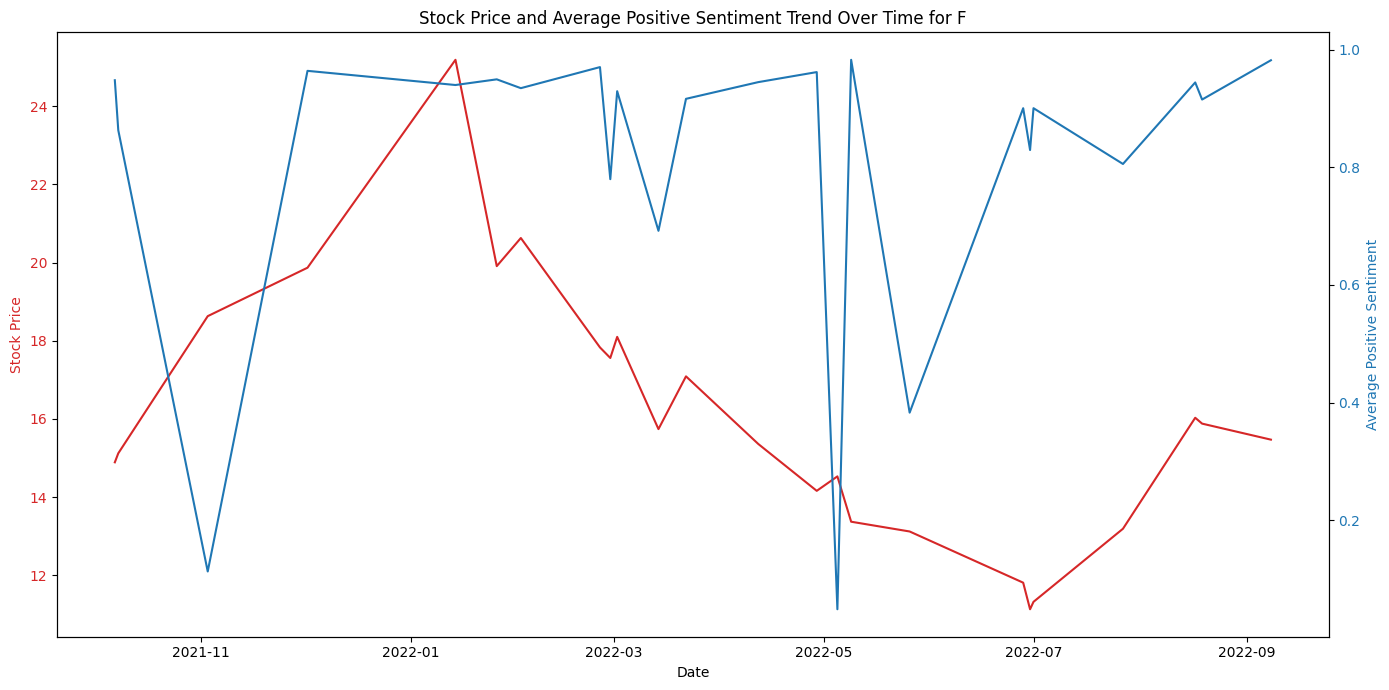

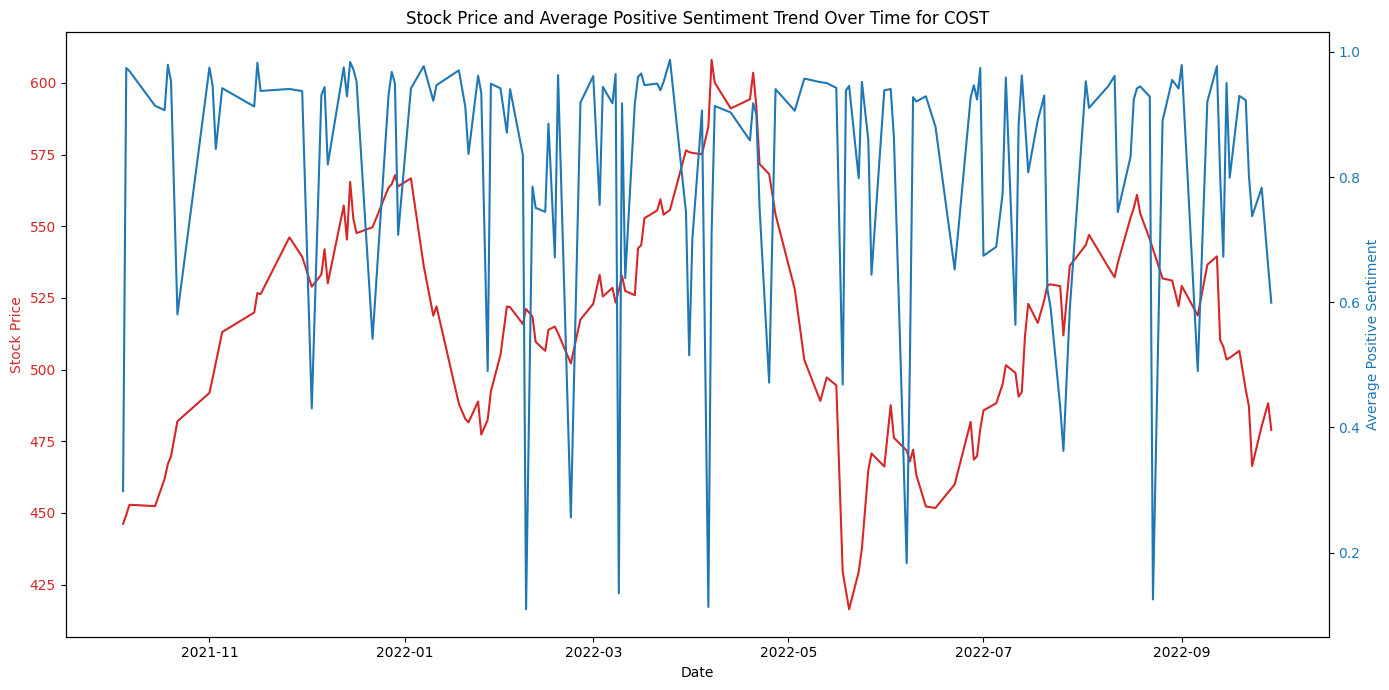

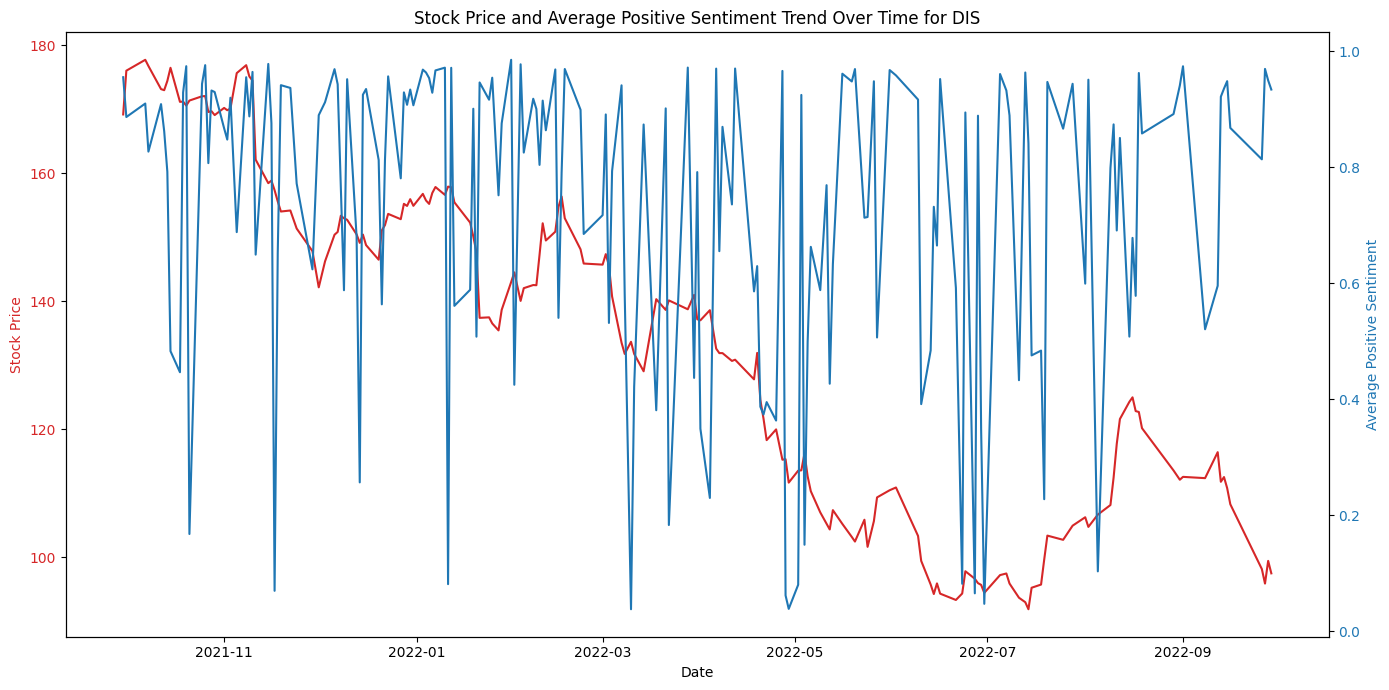

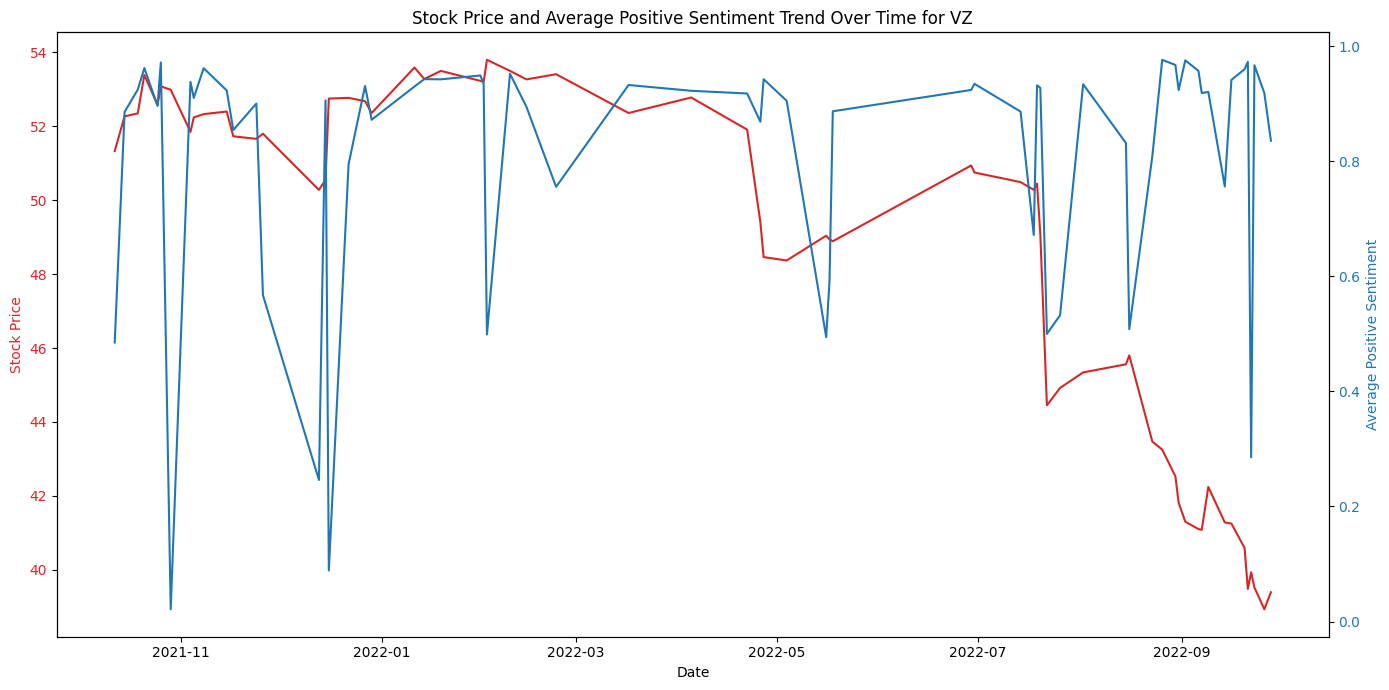

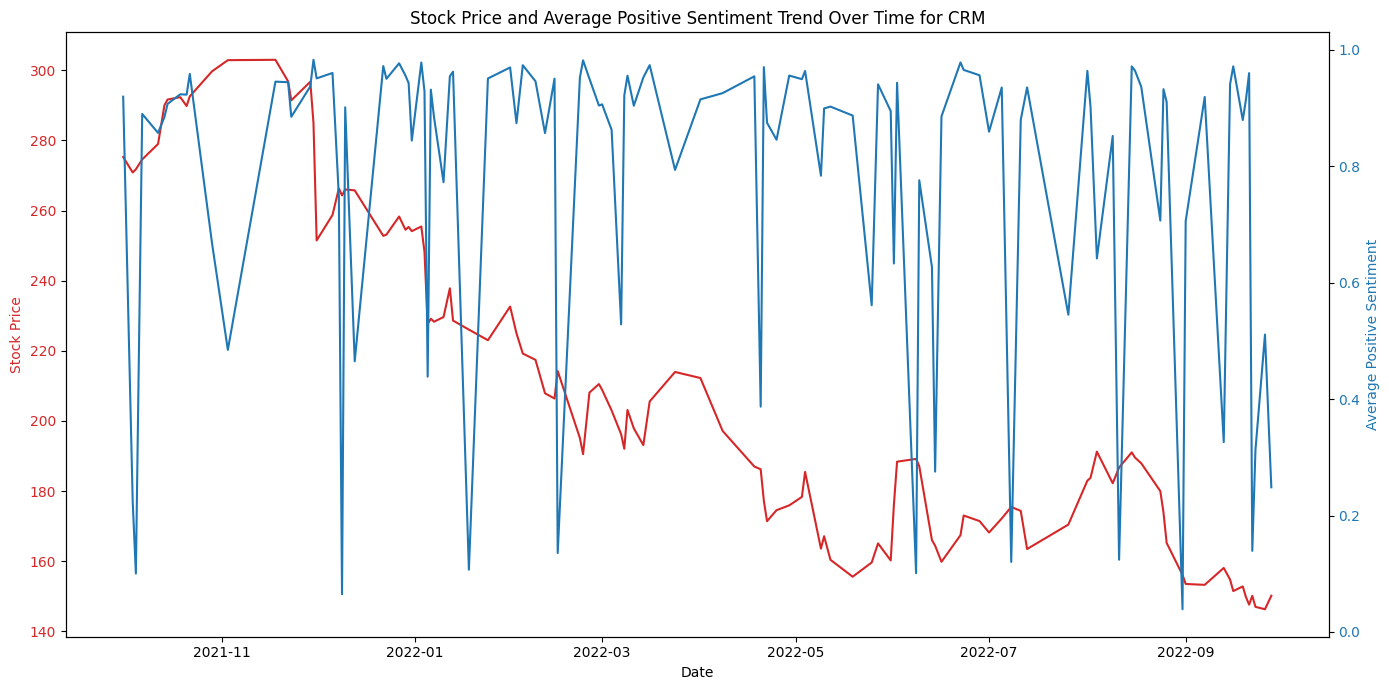

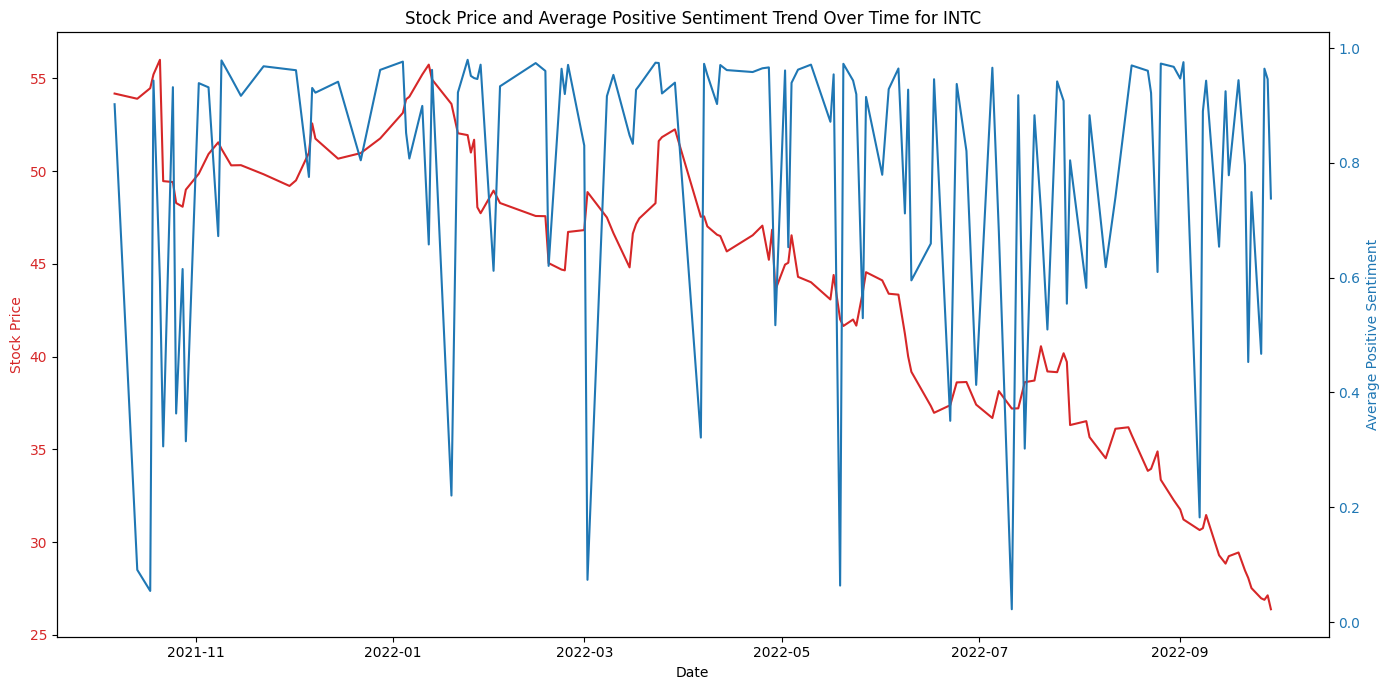

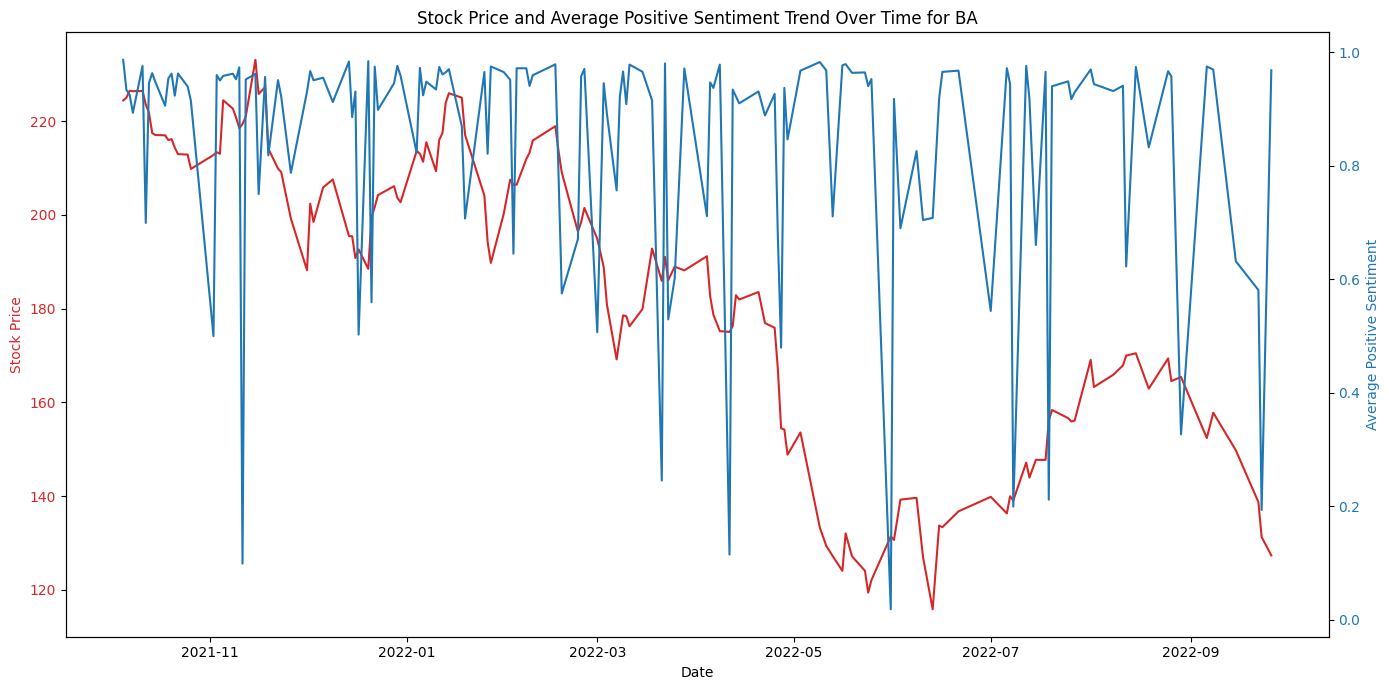

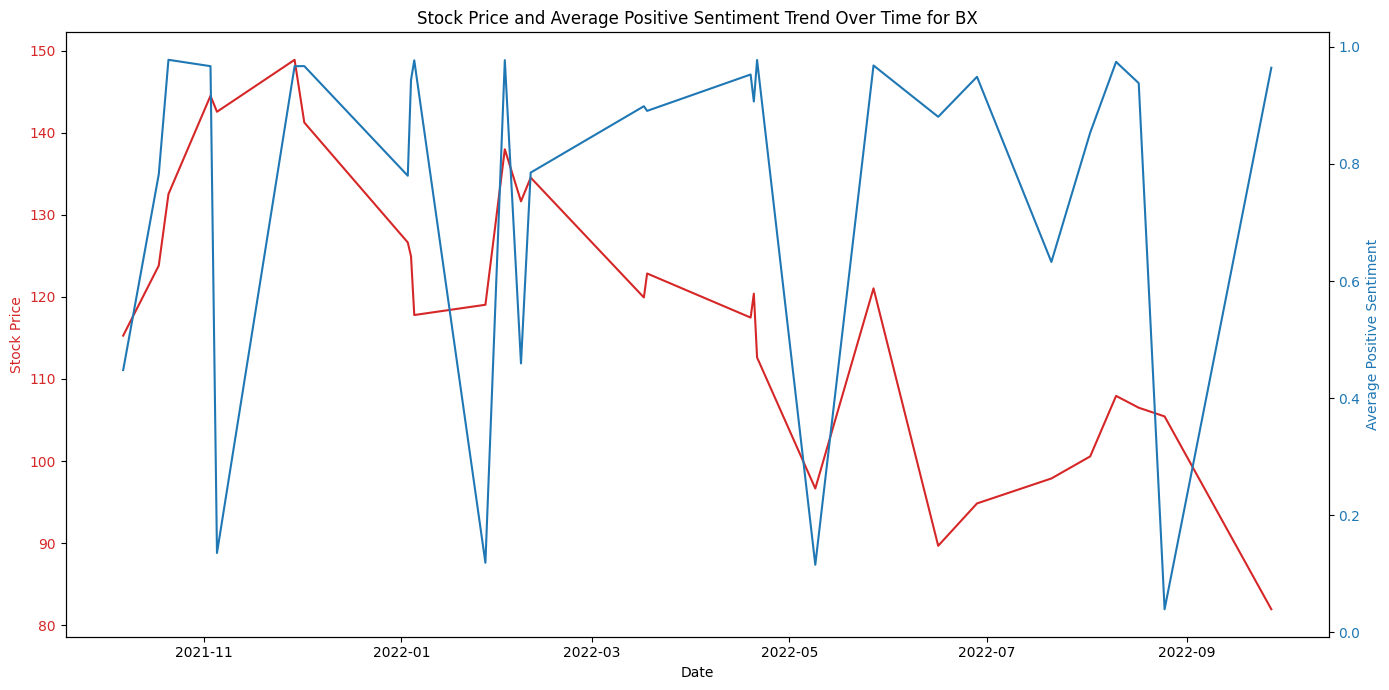

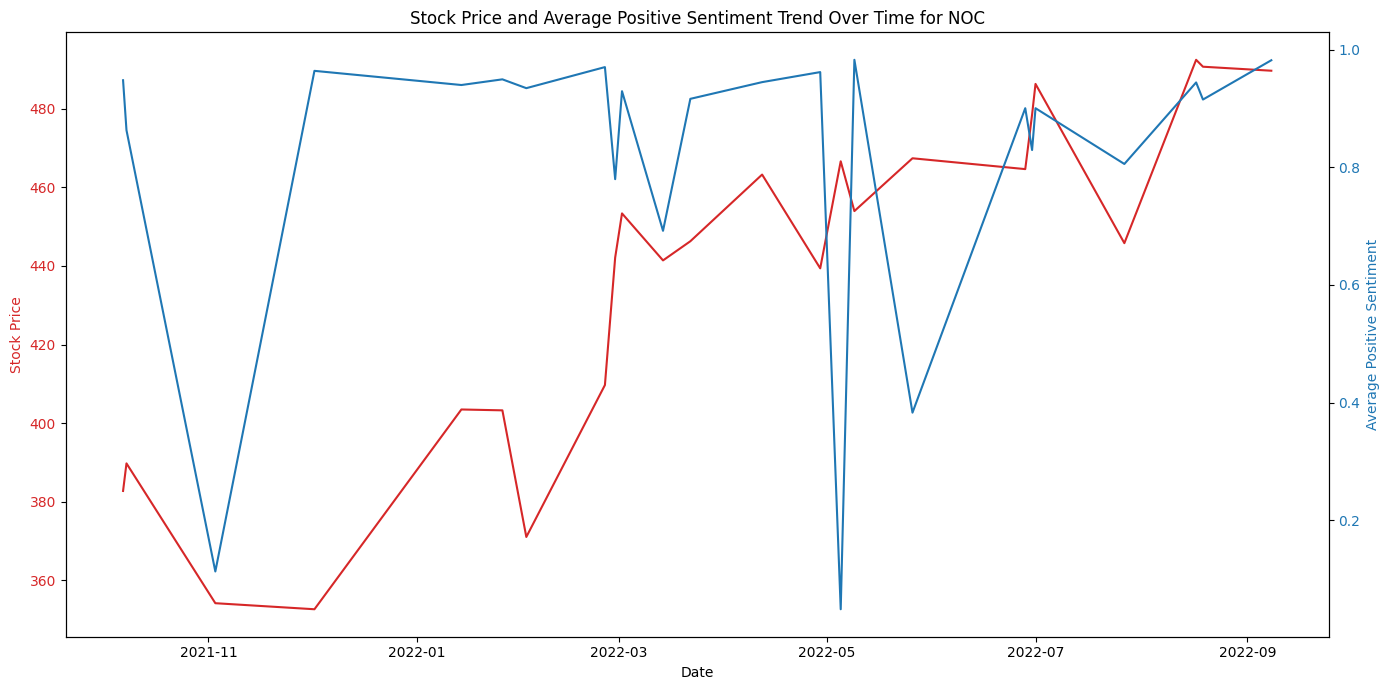

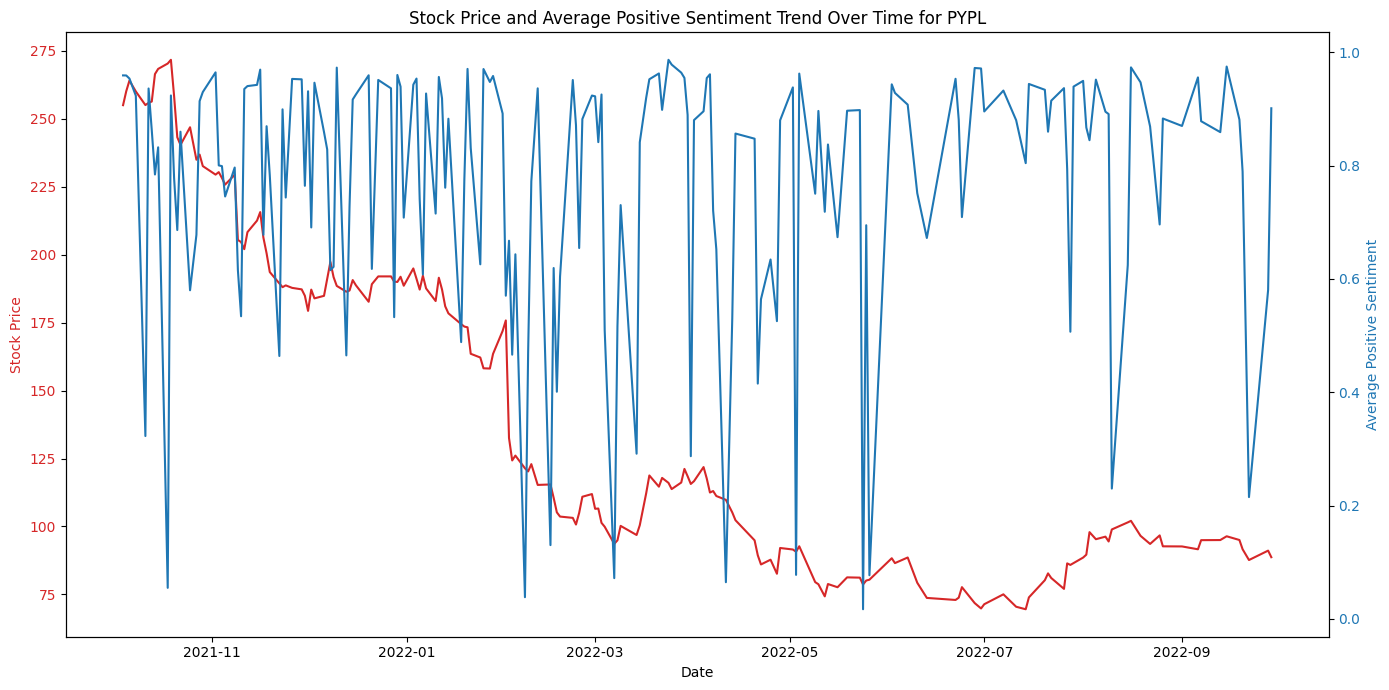

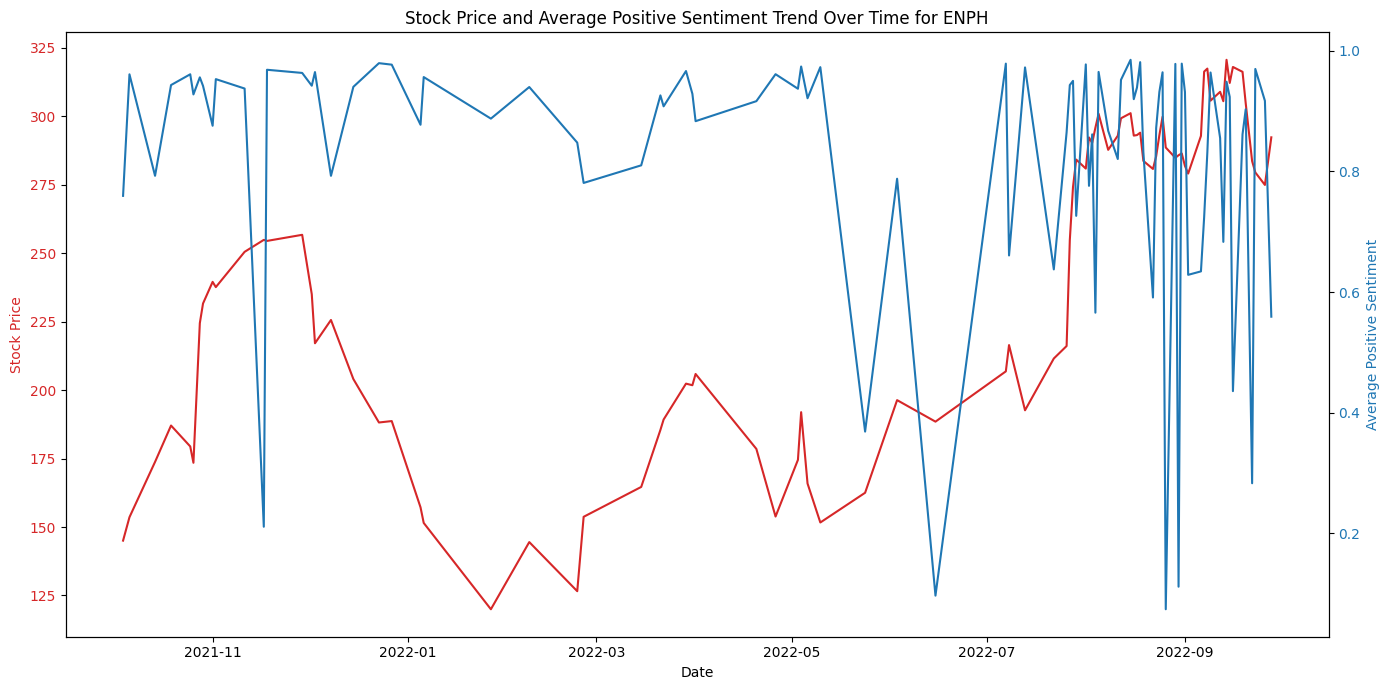

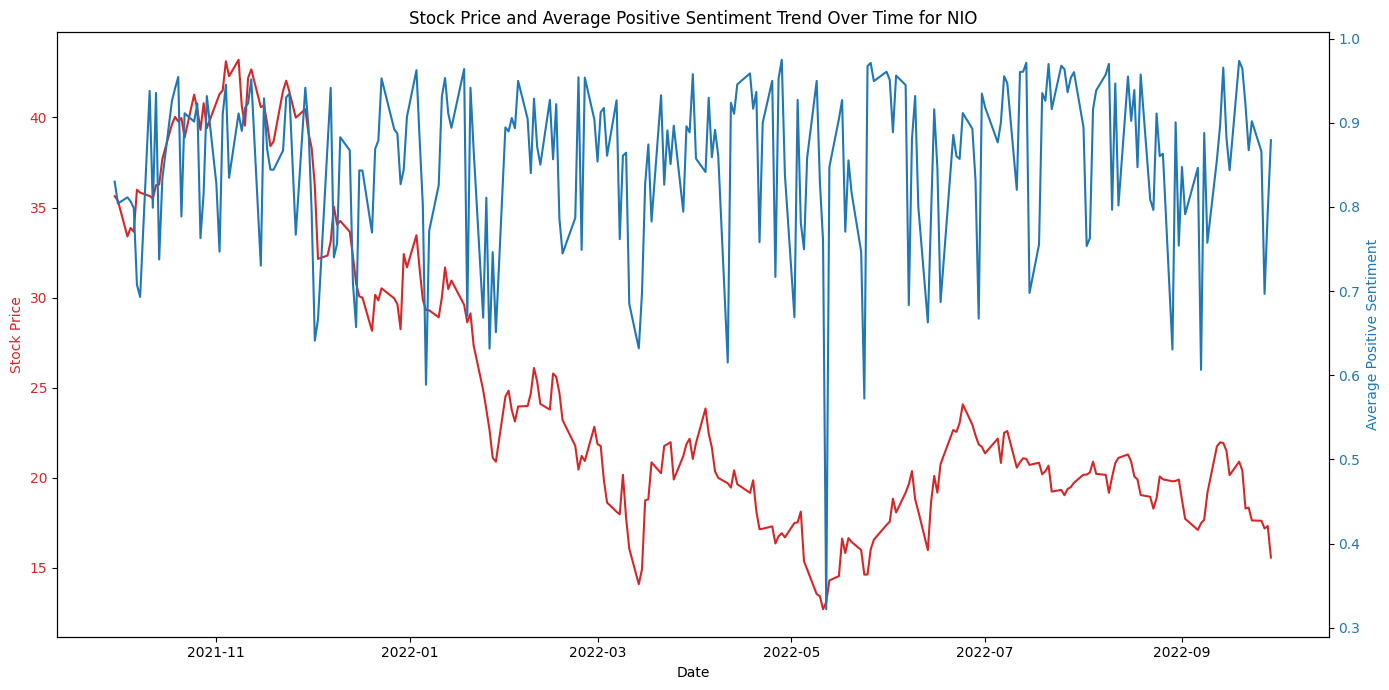

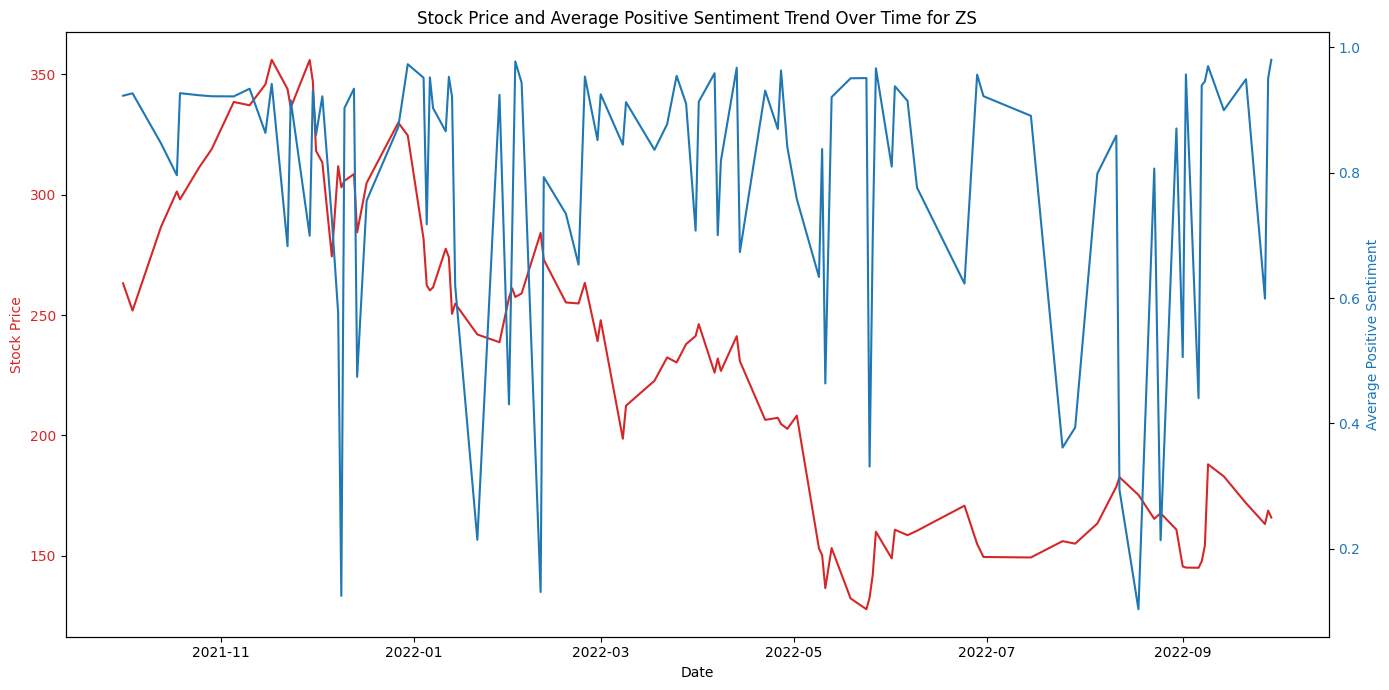

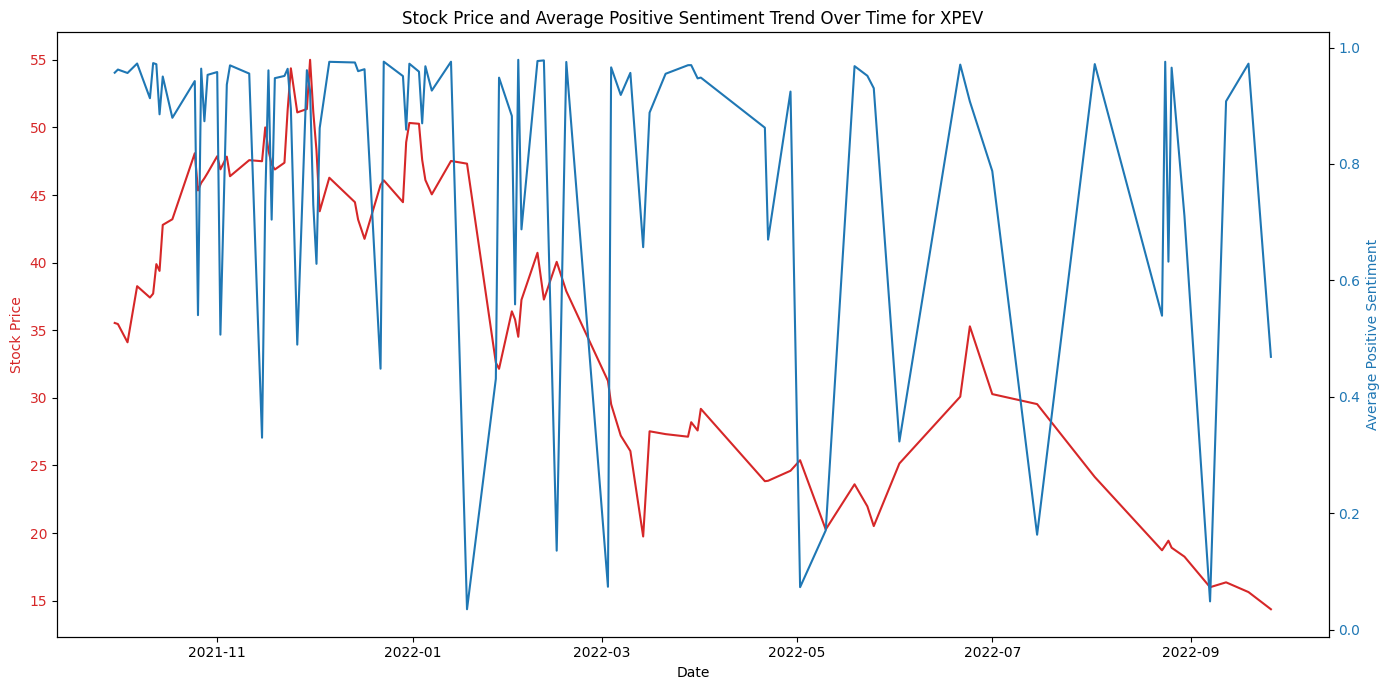

In [53]:
# Make sure the following line is uncommented if you haven't already imported matplotlib
# import matplotlib.pyplot as plt

# Get unique stock names
unique_stocks = merged_with_average_sentiment['Stock Name'].unique()

# Loop through each stock name and create a plot
for stock_name in unique_stocks:
    # Filter for a specific stock
    specific_stock_df = merged_with_average_sentiment[merged_with_average_sentiment['Stock Name'] == stock_name]

    # Set the date as the index for the specific stock
    specific_stock_df.set_index('Date', inplace=True)

    # Start plotting
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot the stock prices
    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Stock Price', color=color)
    ax1.plot(specific_stock_df.index, specific_stock_df['Close'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Instantiate a second y-axis sharing the same x-axis
    ax2 = ax1.twinx()

    # Plot the average positive sentiment score
    color = 'tab:blue'
    ax2.set_ylabel('Average Positive Sentiment', color=color)
    ax2.plot(specific_stock_df.index, specific_stock_df['positive_sentiment'], color=color, marker=' ')
    ax2.tick_params(axis='y', labelcolor=color)

    # Title and layout
    plt.title(f'Stock Price and Average Positive Sentiment Trend Over Time for {stock_name}')
    fig.tight_layout()

    # Show the plot
    plt.show()


In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# 加载数据
tweets_df = pd.read_csv('./sentiment_scores.csv')
stock_prices_df = pd.read_csv('./stock_yfinance_data.csv')

# 选择特定股票的数据
stock_name = 'TSLA'
stock_df = stock_prices_df[stock_prices_df['Stock Name'] == stock_name].copy()

# 将日期列转换为 datetime 类型并且设置为索引
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
tweets_df['Date'] = pd.to_datetime(tweets_df['Date'])

# Group tweets_df by 'Date' and calculate the mean sentiment scores
tweets_df = tweets_df.groupby('Date').mean().reset_index()

# Merge the stock prices and sentiment scores DataFrames on the 'Date' column
merged_df = pd.merge(stock_df, tweets_df, on='Date', how='inner')  # Use 'inner' to only keep rows that have a match in both DataFrames
merged_df.set_index('Date', inplace=True)





C:\Users\guokaifeng\AppData\Local\Temp\ipykernel_4028\1567324739.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tweets_df = tweets_df.groupby('Date').mean().reset_index()


In [29]:
tweets_df = pd.read_csv('./sentiment_scores.csv')
tweets_df.count()

Date                  80793
Tweet                 80793
Stock Name            80793
Company Name          80793
positive_sentiment    80793
negative_sentiment    80793
neutral_sentiment     80793
dtype: int64

In [20]:
# Assume we have complete daily data and find the last day of the previous n months
n_months = 9  # Train using the data of the previous 9 months
window_size = 2
train_end_date = merged_df.index.min() + pd.DateOffset(months=n_months)
test_start_date = train_end_date + pd.DateOffset(days=-window_size)
# Create the training and test sets
train_data = merged_df[:train_end_date]
test_data = merged_df[test_start_date:]

input_feature = ['Close','positive_sentiment','negative_sentiment',"neutral_sentiment",'Volume','Open','High','Low']
# input_feature = ['Close','Open','High','Low']
# input_feature = ['Close','positive_sentiment','negative_sentiment',"neutral_sentiment",'Volume']
# input_feature = ['Close','positive_sentiment','Volume']
input_feature = ['Close','positive_sentiment']


# Data normalization
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(merged_df[input_feature])  # Fit the scaler on all features
train_scaled = scaler.transform(train_data[input_feature])
test_scaled = scaler.transform(test_data[input_feature])

# Convert to PyTorch tensors
train_tensors = torch.tensor(train_scaled, dtype=torch.float32)
test_tensors = torch.tensor(test_scaled, dtype=torch.float32)


# Create data loaders
train_loader = DataLoader(train_tensors, batch_size=64, shuffle=False)
test_loader = DataLoader(test_tensors, batch_size=64, shuffle=False)




def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+1:i+tw+1, 0]  # Modify to select only 'Close' price as label
        inout_seq.append((train_seq, train_label))
    return inout_seq


train_inout_seq = create_inout_sequences(train_tensors, window_size)


# 定义 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size=len(input_feature), hidden_layer_size=256, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions

# 实例化模型
model = LSTMModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# 训练模型
epochs = 150
for i in range(epochs):
    for seq,label in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)
        # single_loss = loss_function(y_pred, seq[-1])
        single_loss = loss_function(y_pred, label.unsqueeze(dim=1))

        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

epoch:   1 loss: 0.42313695
epoch:  26 loss: 0.00322111
epoch:  51 loss: 0.00289443
epoch:  76 loss: 0.00277436
epoch: 101 loss: 0.00267280
epoch: 126 loss: 0.00258590


C:\Users\guokaifeng\AppData\Local\Temp\ipykernel_4028\2242934361.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo['Predicted'] = test_pred_rescaled


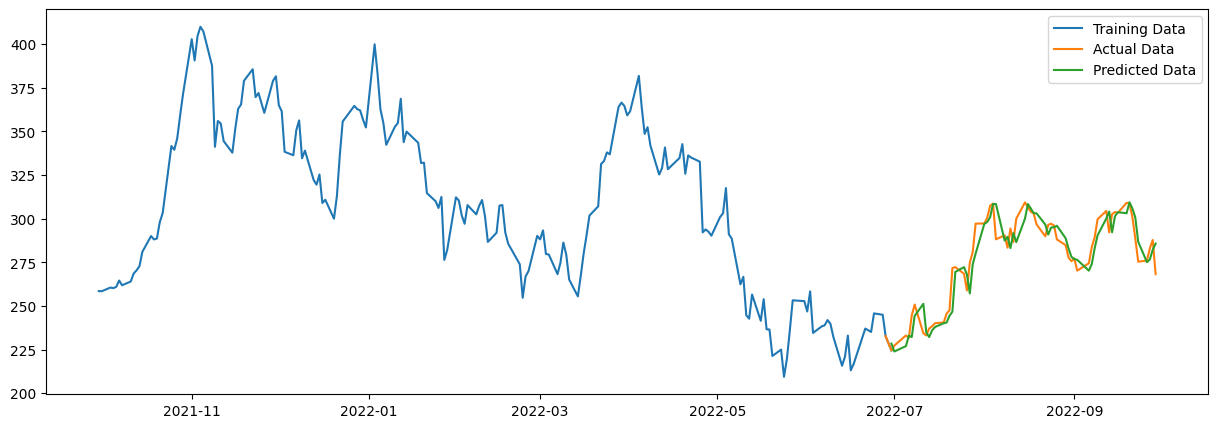

In [21]:
# Assuming the model has been trained and the test data is prepared, let's predict the test data.
model.eval()  # Set the model to evaluation mode
test_inout_seq = create_inout_sequences(test_tensors, window_size)
test_predictions = []
with torch.no_grad():
    for seq,label in test_inout_seq:
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))
        test_predictions.append(model(seq)[-1].detach().numpy())

# Flatten the predictions list
test_predictions = np.array(test_predictions).flatten()

# Since we only predict the 'Close' price, we need to construct the full array to inverse transform
# We'll pad the predictions with zeros for other features
test_pred_full = np.ones((len(test_predictions), len(input_feature)))  # 4 features as per the scaler fit
test_pred_full[:, 0] = test_predictions  # Insert predictions in the first column which corresponds to 'Close' price

# Now we inverse transform our predictions to be on the same scale as the original data
test_pred_rescaled = scaler.inverse_transform(test_pred_full)[:, 0]  # Inverse transform and select only 'Close' price

# We also need to inverse transform the test data
test_data_rescaled = scaler.inverse_transform(test_scaled)[:, 0]  # Select only 'Close' price

offset_date = test_data.index.min() + pd.DateOffset(days=window_size)
end_date = test_data.index.max() - pd.DateOffset(days=window_size)
demo = test_data[offset_date:]
# Add the predicted values to the test_data DataFrame
demo['Predicted'] = test_pred_rescaled

# Now let's plot the results
plt.figure(figsize=(15,5))
plt.plot(train_data['Close'], label='Training Data')
plt.plot(test_data['Close'], label='Actual Data')
plt.plot(demo.index, demo['Predicted'], label='Predicted Data')  # Use test_data index for x-axis
plt.legend()
plt.show()


In [88]:
test_data

Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-06-27  249.366669  252.070007  242.566666  244.919998  244.919998   
2022-06-28  244.483337  249.970001  232.343338  232.663330  232.663330   
2022-06-29  230.500000  231.173340  222.273331  228.490005  228.490005   
2022-06-30  224.509995  229.456665  218.863327  224.473328  224.473328   
2022-07-01  227.000000  230.229996  222.119995  227.263336  227.263336   
...                ...         ...         ...         ...         ...   
2022-09-23  283.089996  284.500000  272.820007  275.329987  275.329987   
2022-09-26  271.829987  284.089996  270.309998  276.010010  276.010010   
2022-09-27  283.839996  288.670013  277.510010  282.940002  282.940002   
2022-09-28  283.079987  289.000000  277.570007  287.809998  287.809998   
2022-09-29  282.760010  283.649994  265.779999  268.209991  268.209991   

              Volume Stock Name  positive_sentiment  negative_sentiment  \
Date                                                                      
2022-06-27  89178300       TSLA            0.743991            0.255328   
2022-06-28  90391200       TSLA            0.749856            0.249491   
2022-06-29  82897200       TSLA            0.677549            0.321742   
2022-06-30  94600500       TSLA            0.648890            0.350465   
2022-07-01  74460300       TSLA            0.721498            0.277833   
...              ...        ...                 ...                 ...   
2022-09-23  63748400       TSLA            0.672853            0.326531   
2022-09-26  58076900       TSLA            0.740275            0.259094   
2022-09-27  61925200       TSLA            0.710607            0.288734   
2022-09-28  54664800       TSLA            0.655242            0.344081   
2022-09-29  77620600       TSLA            0.646177            0.353158   

            neutral_sentiment  
Date                           
2022-06-27           0.000681  
2022-06-28           0.000653  
2022-06-29           0.000709  
2022-06-30           0.000645  
2022-07-01           0.000669  
...                       ...  
2022-09-23           0.000617  
2022-09-26           0.000632  
2022-09-27           0.000659  
2022-09-28           0.000676  
2022-09-29           0.000665  

[67 rows x 10 columns]

In [89]:
demo

Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-06-27  249.366669  252.070007  242.566666  244.919998  244.919998   
2022-06-28  244.483337  249.970001  232.343338  232.663330  232.663330   
2022-06-29  230.500000  231.173340  222.273331  228.490005  228.490005   
2022-06-30  224.509995  229.456665  218.863327  224.473328  224.473328   
2022-07-01  227.000000  230.229996  222.119995  227.263336  227.263336   
...                ...         ...         ...         ...         ...   
2022-09-16  299.609985  303.709991  295.600006  303.350006  303.350006   
2022-09-19  300.089996  309.839996  297.799988  309.070007  309.070007   
2022-09-20  306.910004  313.329987  305.579987  308.730011  308.730011   
2022-09-21  308.290009  313.799988  300.630005  300.799988  300.799988   
2022-09-22  299.859985  301.290009  285.820007  288.589996  288.589996   

              Volume Stock Name  positive_sentiment  negative_sentiment  \
Date                                                                      
2022-06-27  89178300       TSLA            0.743991            0.255328   
2022-06-28  90391200       TSLA            0.749856            0.249491   
2022-06-29  82897200       TSLA            0.677549            0.321742   
2022-06-30  94600500       TSLA            0.648890            0.350465   
2022-07-01  74460300       TSLA            0.721498            0.277833   
...              ...        ...                 ...                 ...   
2022-09-16  87087800       TSLA            0.744055            0.255304   
2022-09-19  60231200       TSLA            0.772691            0.226649   
2022-09-20  61642800       TSLA            0.674332            0.325032   
2022-09-21  62555700       TSLA            0.720083            0.279240   
2022-09-22  70545400       TSLA            0.643619            0.355723   

            neutral_sentiment   Predicted  
Date                                       
2022-06-27           0.000681  219.991401  
2022-06-28           0.000653  228.898677  
2022-06-29           0.000709  229.603459  
2022-06-30           0.000645  240.428083  
2022-07-01           0.000669  242.917474  
...                       ...         ...  
2022-09-16           0.000642  281.780382  
2022-09-19           0.000659  269.733313  
2022-09-20           0.000636  272.257696  
2022-09-21           0.000677  284.630062  
2022-09-22           0.000658  288.090597  

[62 rows x 11 columns]

In [63]:
train_data

Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
2021-10-04  265.500000  268.989990  258.706665  260.510010  260.510010   
2021-10-05  261.600006  265.769989  258.066681  260.196655  260.196655   
2021-10-06  258.733337  262.220001  257.739990  260.916656  260.916656   
...                ...         ...         ...         ...         ...   
2022-06-24  237.470001  246.066666  236.086670  245.706665  245.706665   
2022-06-27  249.366669  252.070007  242.566666  244.919998  244.919998   
2022-06-28  244.483337  249.970001  232.343338  232.663330  232.663330   
2022-06-29  230.500000  231.173340  222.273331  228.490005  228.490005   
2022-06-30  224.509995  229.456665  218.863327  224.473328  224.473328   

              Volume Stock Name  positive_sentiment  negative_sentiment  \
Date                                                                      
2021-09-30  53868000       TSLA            0.746199            0.253175   
2021-10-01  51094200       TSLA            0.745360            0.254004   
2021-10-04  91449900       TSLA            0.618326            0.381001   
2021-10-05  55297800       TSLA            0.660656            0.338616   
2021-10-06  43898400       TSLA            0.748319            0.250980   
...              ...        ...                 ...                 ...   
2022-06-24  95770800       TSLA            0.717043            0.282274   
2022-06-27  89178300       TSLA            0.743991            0.255328   
2022-06-28  90391200       TSLA            0.749856            0.249491   
2022-06-29  82897200       TSLA            0.677549            0.321742   
2022-06-30  94600500       TSLA            0.648890            0.350465   

            neutral_sentiment  
Date                           
2021-09-30           0.000625  
2021-10-01           0.000636  
2021-10-04           0.000673  
2021-10-05           0.000729  
2021-10-06           0.000701  
...                       ...  
2022-06-24           0.000683  
2022-06-27           0.000681  
2022-06-28           0.000653  
2022-06-29           0.000709  
2022-06-30           0.000645  

[189 rows x 10 columns]

In [64]:
test_data

Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-06-21  224.603333  243.576660  224.333328  237.036667  237.036667   
2022-06-22  234.503326  246.833328  233.826660  236.086670  236.086670   
2022-06-23  237.906662  239.316666  228.636673  235.070007  235.070007   
2022-06-24  237.470001  246.066666  236.086670  245.706665  245.706665   
2022-06-27  249.366669  252.070007  242.566666  244.919998  244.919998   
...                ...         ...         ...         ...         ...   
2022-09-23  283.089996  284.500000  272.820007  275.329987  275.329987   
2022-09-26  271.829987  284.089996  270.309998  276.010010  276.010010   
2022-09-27  283.839996  288.670013  277.510010  282.940002  282.940002   
2022-09-28  283.079987  289.000000  277.570007  287.809998  287.809998   
2022-09-29  282.760010  283.649994  265.779999  268.209991  268.209991   

               Volume Stock Name  positive_sentiment  negative_sentiment  \
Date                                                                       
2022-06-21  122793000       TSLA            0.723204            0.276088   
2022-06-22  101107500       TSLA            0.705975            0.293345   
2022-06-23  104202600       TSLA            0.647222            0.352112   
2022-06-24   95770800       TSLA            0.717043            0.282274   
2022-06-27   89178300       TSLA            0.743991            0.255328   
...               ...        ...                 ...                 ...   
2022-09-23   63748400       TSLA            0.672853            0.326531   
2022-09-26   58076900       TSLA            0.740275            0.259094   
2022-09-27   61925200       TSLA            0.710607            0.288734   
2022-09-28   54664800       TSLA            0.655242            0.344081   
2022-09-29   77620600       TSLA            0.646177            0.353158   

            neutral_sentiment  
Date                           
2022-06-21           0.000709  
2022-06-22           0.000680  
2022-06-23           0.000666  
2022-06-24           0.000683  
2022-06-27           0.000681  
...                       ...  
2022-09-23           0.000617  
2022-09-26           0.000632  
2022-09-27           0.000659  
2022-09-28           0.000676  
2022-09-29           0.000665  

[71 rows x 10 columns]

C:\Users\guokaifeng\AppData\Local\Temp\ipykernel_3988\4025185028.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_sentiments = tesla_df.resample('M').sum()


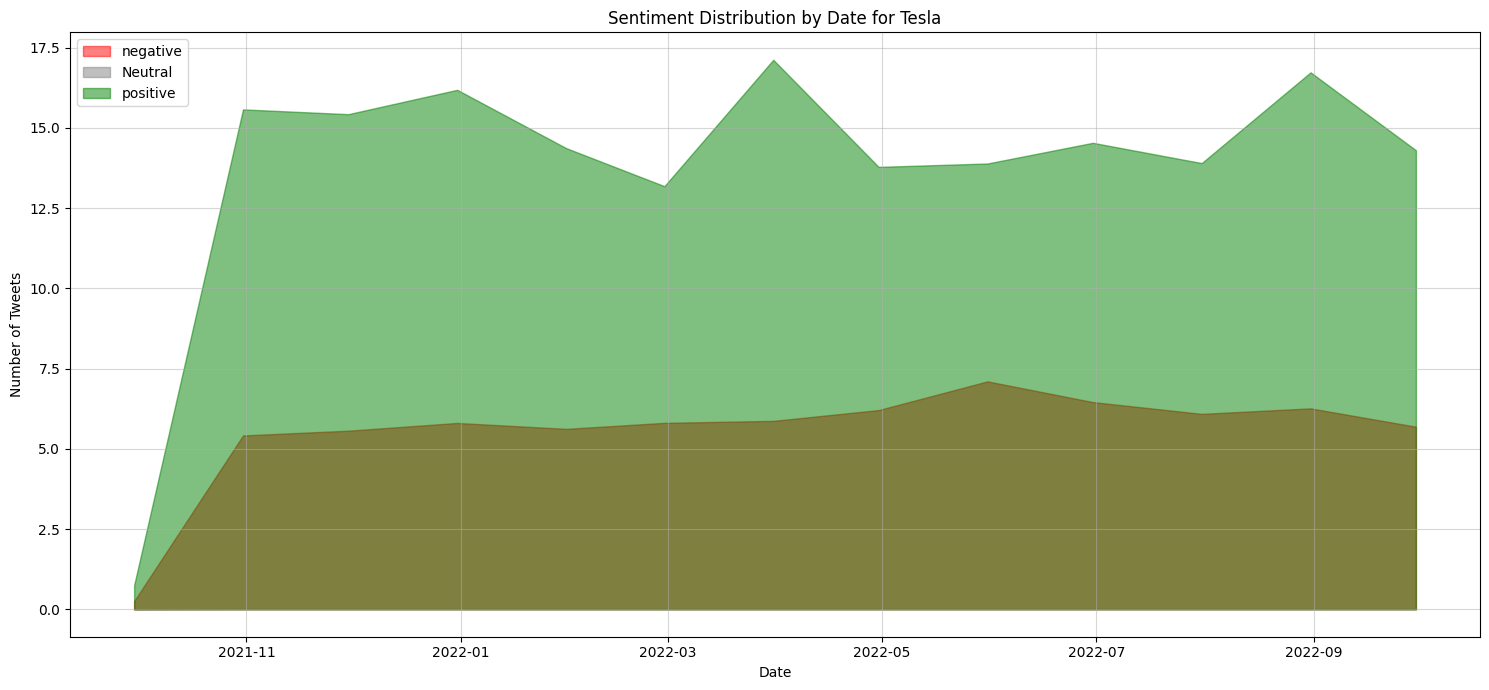

In [32]:
import matplotlib.pyplot as plt

# 根据日期过滤Tesla的数据
tesla_df = merged_df[merged_df['Stock Name'] == 'TSLA']

# 将数据按月份分组并求和
monthly_sentiments = tesla_df.resample('M').sum()

# 绘制图形
plt.figure(figsize=(15,7))

plt.fill_between(monthly_sentiments.index, monthly_sentiments['negative_sentiment'], color='red', label='negative', alpha=0.5)
plt.fill_between(monthly_sentiments.index, monthly_sentiments['neutral_sentiment'], color='gray', label='Neutral', alpha=0.5)
plt.fill_between(monthly_sentiments.index, monthly_sentiments['positive_sentiment'], color='green', label='positive', alpha=0.5)

# 设置图形标题和轴标签
plt.title('Sentiment Distribution by Date for Tesla')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.legend(loc='upper left')

# 显示图形
plt.tight_layout()
plt.grid(True, alpha=0.5)
plt.show()
